## Seminar 7

In [11]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torch.distributions import Normal

In [12]:
def plot_grad_mean_std(mu_supp, grads):
    mu = mu_supp.detach()
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    for key, grad in grads.items():
        grad_mean = grad.mean(0)
        grad_std = grad.std(0)
        ax[0].plot(mu, grad_mean, label=key)
        ax[0].fill_between(
            mu,
            grad_mean - grad_std,
            grad_mean + grad_std,
            alpha=0.2)

        ax[1].plot(mu, grad_std, label=key)

    ax[0].set_xlabel('$\mu$')
    ax[1].set_xlabel('$\mu$')
    ax[0].set_ylabel('Gradient mean')
    ax[1].set_ylabel('Gradient std')
    ax[0].legend()
    ax[0].grid()


#  1. Task
$$ \max_\mu \mathbb E_{q(\xi \mid \mu, 1)} \xi^2 $$

In [13]:
M = 4096
gradient_dict = {}

mu_supp = torch.linspace(-4, 4, 128).requires_grad_(True)
q_xi = Normal(loc=mu_supp, scale=torch.ones_like(mu_supp))

def f(x):
    return x ** 2

# REINFORCE

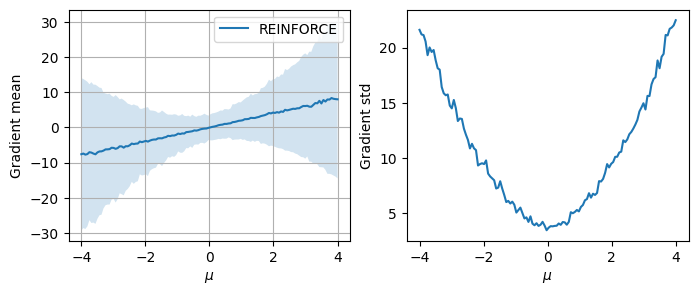

In [14]:
grads = torch.empty(M, 128)

for m in range(M):
    xi_samples = q_xi.sample()
    surrogate = (f(xi_samples) * q_xi.log_prob(xi_samples)).sum()
    surrogate.backward()

    grads[m] = mu_supp.grad
    mu_supp.grad.zero_()

gradient_dict['REINFORCE'] = grads
plot_grad_mean_std(mu_supp, gradient_dict)


# REINFORCE  for $K$ points

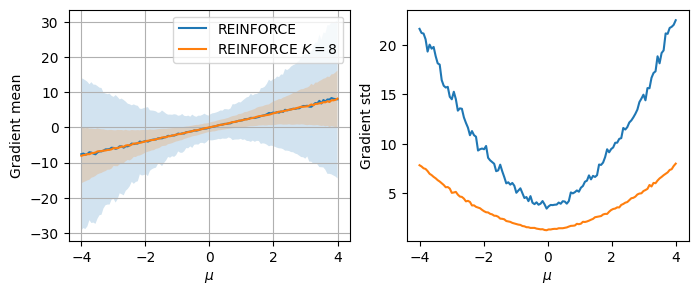

In [15]:

grads = torch.empty(M, 128)
K = 8

for m in range(M):
    xi_samples = q_xi.sample((K, ))
    surrogate = (f(xi_samples) * q_xi.log_prob(xi_samples)).mean(0).sum()
    surrogate.backward()

    grads[m] = mu_supp.grad
    mu_supp.grad.zero_()

gradient_dict['REINFORCE $K={}$'.format(K)] = grads
plot_grad_mean_std(mu_supp, gradient_dict)


# REINFORCE +  untrainable baseline

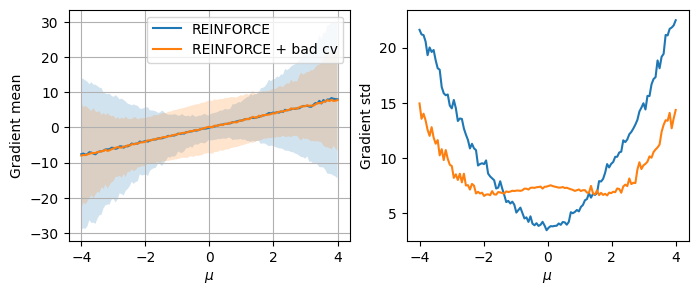

In [16]:
# delete everything
gradient_dict = {'REINFORCE': gradient_dict['REINFORCE']}

grads = torch.empty(M, 128)

for m in range(M):
    xi_samples = q_xi.sample()
    diff = f(xi_samples) - 10
    surrogate = (diff * q_xi.log_prob(xi_samples)).sum()
    surrogate.backward()

    grads[m] = mu_supp.grad
    mu_supp.grad.zero_()

gradient_dict['REINFORCE + bad cv'] = grads
plot_grad_mean_std(mu_supp, gradient_dict)


# Analytic baseline
### ($\lambda=-(\mu^2 + 3)$, that was derived in the class)

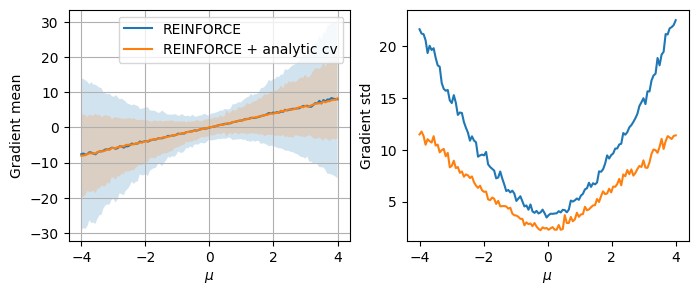

In [17]:
# delete everything
gradient_dict = {'REINFORCE': gradient_dict['REINFORCE']}

grads = torch.empty(M, 128)

for m in range(M):
    xi_samples = q_xi.sample()
    diff = f(xi_samples) - (mu_supp.detach() ** 2 + 3)
    surrogate = (diff * q_xi.log_prob(xi_samples)).sum()
    surrogate.backward()

    grads[m] = mu_supp.grad
    mu_supp.grad.zero_()

gradient_dict['REINFORCE + analytic cv'] = grads
plot_grad_mean_std(mu_supp, gradient_dict)


# Train baseline

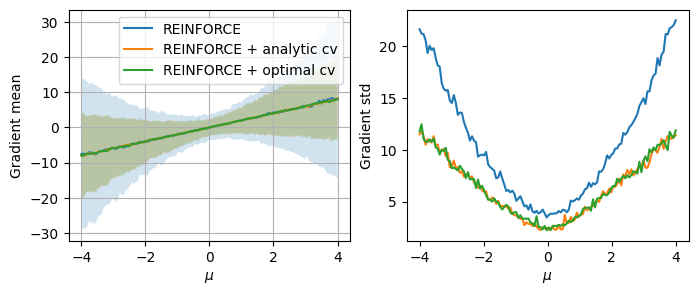

In [18]:
grads = torch.empty(M, 128)

# estimate cov / var
with torch.no_grad():
    K = 512
    xi_samples = q_xi.sample((K,))
    f_xi = f(xi_samples)
    cov = (f_xi * (mu_supp - xi_samples) ** 2).mean(0)
    var = (mu_supp - xi_samples).var(0)
    cov_var = cov / var

for m in range(M):
    xi_samples = q_xi.sample()
    diff = (f(xi_samples) - cov_var)
    surrogate = (diff * q_xi.log_prob(xi_samples)).sum()
    surrogate.backward()

    grads[m] = mu_supp.grad
    mu_supp.grad.zero_()

gradient_dict['REINFORCE + optimal cv'] = grads
plot_grad_mean_std(mu_supp, gradient_dict)

# Reparametrization

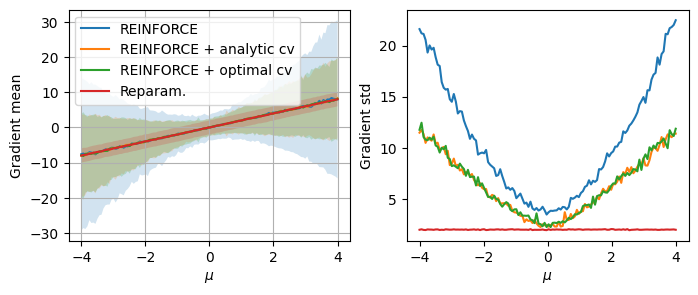

In [19]:

grads = torch.empty(M, 128)

for m in range(M):
    xi_samples = q_xi.rsample()
    f_xi = f(xi_samples)
    surrogate = f_xi.sum()
    surrogate.backward()

    grads[m] = mu_supp.grad
    mu_supp.grad.zero_()

gradient_dict['Reparam.'] = grads
plot_grad_mean_std(mu_supp, gradient_dict)